In [1]:
import numpy as np
from numpy import random as rd
import scipy.linalg as la
import matplotlib.pyplot as plt

In [2]:
# HELPER FUNCTIONS #
def vec(theta):
    """construct a 2D vector pointing in a given direction"""
    return np.array([np.cos(theta), np.sin(theta)])
def plotvec(v, ax, color='k', linestyle='-'):
    """draw a 2D vector"""
    ax.plot([0, v[0]], [0, v[1]], color=color, linestyle=linestyle)
def angular_error(v1, v2):
    """computes absolute angular error between two vectors"""
    vdot = v1 @ v2 / np.sqrt((v1 ** 2).sum() * (v2 ** 2).sum())
    return np.rad2deg(np.arccos(vdot))

# Neural Coding Tutorial CCNSS 2019

## 1) The Tuning Curve + Noise model
A classic model used for studying coding in neural populations is the tuning curve plus noise model:
\begin{equation}
r_i(s) = f_i(s) + \xi_i \\
\xi_i \sim \mathcal{P}
\end{equation}
where 
* $r_i(s)$ designates the response of the $i$th neuron to stimulus $s$
* $\mathcal{P}$ is some 0-mean noise distribution (e.g. Gaussian)
* $f_i(s) = \mathbb{E}[r_i(s)]$, the mean response of neuron $i$ to simulus $s$, is called the tuning curve of neuron $i$: how its mean response depends on the stimulus.

### <span style="color:green">The cricket cercal system</span>
A classic biological system well-characterized by this model is the cricket cercal sensory system, which senses wind direction via mechanoreceptors on two antenna-like appendages on the cricket's butt. These mechanoreceptors pass their activity onto a set interneurons, four of which seem to play a crucial role in passing on the relevant sensory information to downstream areas (Miller, Jacobs & Theunissen, 1991). Their response to a particular wind direction $\theta \in [0, 2\pi]$ is captured well by the tuning curve + noise model with
\begin{equation}
    f_i(\theta) = \frac{r_{max}}{1 - \alpha} \left[ \cos(\theta - \theta^*_i) - \alpha\right]_+ \\
    \xi_i \sim \mathcal{N}(0, \sigma^2)
\end{equation}
where $r_{max} > 0$ and $-1 \leq \alpha \leq 1$. The operation $[x]_+$ is referred to as *rectification*: return $x$ if it is positive and 0 otherwise.

Here is a pair of functions to simulate responses from this model:

In [3]:
def cosine_tuning(stimuli, params):
    """
    Evaluated the rectified cosine tuning curve
    Arguments:
        stimuli: list or numpy array of wind directions (between 0 and 2*pi)
        params: list of 3 scalars setting the tuning curve parameters
            params[0]: r_max parameter
            params[1]: alpha parameter
            params[2]: theta^*_i parameter
    Outputs:
        vector of evaluations of the tuning curve with these parameters at each 
        of the wind directions in stimuli
    """
    r_max, alpha, theta_i = params
    return r_max * np.maximum(np.cos(stimuli - theta_i) - alpha, 0) / (1 - alpha)


def simulate(stimuli, params, sigma=0.05):
    """
    Simulate responses from the rectified cosine tuning curve + Gaussian noise model
    Arguments:
        stimuli, params: arguments for cosine_tuning() function defined above
        sigma: scalar setting the standard deviation of the Gaussian noise
               I have set this to a reasonable default value you can use for the rest of the notebook
    Outputs:
        vector of responses to each of wind directions in stimuli for a neuron
        with the given tuning curve parameters
    """
    f = cosine_tuning(stimuli, params)
    if np.isscalar(f):
        return f + sigma * rd.randn()
    else:
        return f + sigma * rd.randn(len(f))

### 1.1) Plot cricket cercal interneuron tuning curves for different parameter settings.
Pick some parameter settings and plot a cell's responses as a function of wind direction $\theta$. Do this for different values of $\theta_i^*$ and $\alpha$ - how do these affect the neuron's tuning curve? How do we interpret these two parameters?

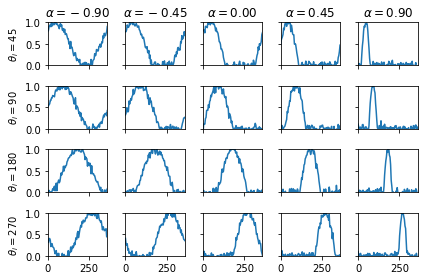

In [4]:
r_max = 1.0
# Pick theta^* to sweep over
theta_i = [np.pi / 4, np.pi / 2, np.pi, 3*np.pi / 2]
# Pick alphas to sweep over
alphas = np.linspace(-0.9, 0.9, 5)
# Pick stimulus values at which to evaluate the tuning curve
stimuli = np.linspace(0, 2*np.pi, 100)
# Set up axes for plotting
fig, axs = plt.subplots(len(theta_i), len(alphas), sharex=True, sharey=True)
# For each value of theta^*:
for i, th in enumerate(theta_i):
    # For each value of alpha:
    for j, a in enumerate(alphas):
        # Simulate neural response to each stimulus
        r = simulate(stimuli, [r_max, a, th])
        # Plot it as a function of wind direction
        axs[i, j].plot(np.rad2deg(stimuli), r)
# Formatting
[ax.set_title('$\\alpha=%.2f$' %a) for a, ax in zip(alphas, axs[0, :])]
[ax.set_ylabel('$\\theta_i=%.0f$' %np.rad2deg(th)) for th, ax in zip(theta_i, axs[:, 0])]
[ax.set_xlim([0, 360]) for ax in axs.flatten()]
[ax.set_ylim([0, r_max]) for ax in axs.flatten()]
plt.tight_layout()

## 2) The Population Vector (PV) decoding algorithm

The above provides an *encoding model* for how the neurons in this population respond to different stimulus values. But what really matters for the cricket is being able to *decode* the wind direction from the population activity of its cercal system. How can we decode wind direction from the responses of these four neurons? One classic algorithm for doing this is called the **population vector alogrithm** (Georgopoulos, Schwartz & Kettner, 1986):

1. find the direction $\theta$ to which each neuron responds most strongly:
\begin{equation}
    \hat{\theta_i} = \arg \max_\theta r_i(\theta)
\end{equation}
called the *preferred direction* of neuron $i$

2. for a given stimulus, decode the direction by a linear combination of the neurons' preferred directions weighted by their responses to the stimulus:
\begin{equation}
    \hat{\mathbf{v}}^{\text{PV}} = \sum_i r_i(\theta) \hat{\mathbf{v}}_i
\end{equation}
where $\hat{\mathbf{v}}_i$ is a unit vector pointing in the preferred direction of neuron $i$:
\begin{equation}
    \hat{\mathbf{v}}_i = 
    \begin{bmatrix}
        \cos \hat{\theta_i} \\
        \sin \hat{\theta_i}
    \end{bmatrix}
\end{equation}

The decoded direction $\hat{\theta}^{\text{PV}}$ is then given by the direction in which $\hat{\mathbf{v}}^{\text{PV}}$ points.

### 2.1) Write a function that estimates the preferred direction of a neuron
This function should take as argument a neuron's tuning curve parameters $\theta_i^*, \alpha, r_{max}$ and outputs an estimate of its preferred direction.

In [5]:
def pref_direction(params):
    """
    Function to calculate preferred direction of a neuron
    Given the tuning curve parameters provided as arguments, 
    should simulate responses to a range of wind directions 
    and find the direction to which the neuron responds most strongly.
    Arguments:
        params: parameter vector for stimulate() and cosine_tuning() 
                functions above
    Outputs:
        a scalar between 0 and 2*pi, indicating the preferred direction 
        of a neuron with those parameters
    """
    # Simulate neural response to a bunch of stimuli over many trials
    stimuli = np.linspace(0, 2*np.pi, 100)
    n_trials = 100
    r = np.zeros(len(stimuli))
    for _ in range(n_trials):
        r += simulate(stimuli, params)
    # Average over trials
    r = r / n_trials
    # Find the stimulus value that produces the highest average response
    return stimuli[np.argmax(r)]

### 2.2) Use the PV algorithm to decode wind direction from the cercal interneuron population
Use the following parameters for the four cercal interneurons, measured experimentally by Miller, Jacobs & Theunissen (1991):
\begin{gather}
    \alpha = -0.14 \\
    \theta^*_1 = 45^o \\
    \theta^*_2 = 135^o \\
    \theta^*_3 = 225^o \\
    \theta^*_4 = 315^o
\end{gather}
Estimate their preferred directions and then show a single wind direction $\theta$ and attempt to decode it. Plot the true presented wind direction as a 2D vector and plot the decoded estimate $\hat{\mathbf{v}}^{\text{PV}}$ (use the helper function `plotvec()` for this). How well aligned are they?

Evaluate the quality of the decoded estimate over many stimulus values $\theta_1, \ldots, \theta_m$ by computing the mean angular decoding error
\begin{equation}
    \frac{1}{m}\sum_{i=1}^m \left| \theta_m - \hat{\theta}^{\text{PV}} \right| = \frac{1}{m}\sum_{i=1}^m\cos^{-1} \left( \frac{\mathbf{v}(\theta_m)^T\hat{\mathbf{v}}^{\text{PV}}}{\|\mathbf{v}(\theta_m)\|\|\hat{\mathbf{v}}^{\text{PV}}\|} \right)
\end{equation}
where $\mathbf{v}(\theta_m)$ is just a unit vector pointing in the direction $\theta_m$ (use the helper function `vec()` for constructing this vector). You can use the helper function `angular_error()` defined at the top of the notebook to compute the decoding error. Try doing this for several values of $\alpha$.
* For which $\alpha$ is the error minimized? 
* Is this close to the actually measured value $\alpha = -0.14$? 
* Theunissen & Miller (1991) used information-theoretic methods to estimate that an optimal decoder would have an average decoding error of $\sim 5^o$ for the tuning curves measured in the data (i.e. with $\alpha = -0.14$). Does this match your simulations?

Text(0.5, 1.0, 'angular error = 10.34 degrees')

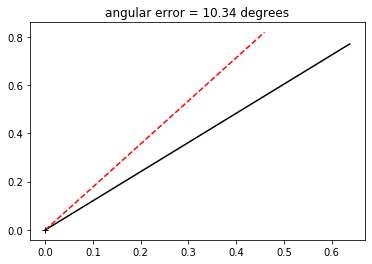

In [6]:
# Set tuning curve parameters
r_max = 1.0
theta_i = np.arange(np.pi/4, 2*np.pi, np.pi/2)
alpha = -0.14
# Estimate preferred directions
pref = [pref_direction([r_max, alpha, th]) for th in theta_i]
# Simulate neural response to a random wind direction and decode
stim = rd.rand() * 2 * np.pi
resp = [simulate(stim, [r_max, alpha, th]) for th in theta_i]
vhat = np.sum([r * vec(p) for r, p in zip(resp, pref)], axis=0)
# Plot decoded wind direction and true wind direction as vectors, compute angular decoding error
fig, ax = plt.subplots()
vstim = vec(stim)
plotvec(vstim, ax, color='k', linestyle='-')
plotvec(vhat, ax, color='r', linestyle='--')
ax.plot(0, 0, 'k+') # mark origin
ax.set_title('angular error = %.2f degrees' % angular_error(vhat, vstim))

Text(0, 0.5, 'mean decoding error (degrees)')

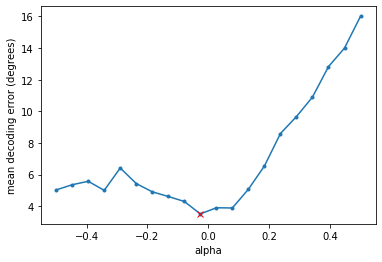

In [7]:
# Pick alphas to evaluate
alphas = np.linspace(-0.5, 0.5, 20)
# Generate stimuli for which to evaluate decoding error for each alpha
m = 200 # number of stimuli to use
stimuli = rd.rand(m) * 2 * np.pi
# Placeholders
error = np.zeros(len(alphas))
# For each alpha:
for i, a in enumerate(alphas):
    # Estimate preferred directions for each neuron
    pref = [pref_direction([r_max, a, th]) for th in theta_i]
    # Simulate population response to each stimulus
    resp = [simulate(stimuli, [r_max, a, th]) for th in theta_i]
    # Use preferred directions to decode stimulus from each response
    # Calculate angular decoding error for each decoded stimulus estimate
    for j, s in enumerate(stimuli):
        vhat = np.sum([r[j] * vec(p) for r, p in zip(resp, pref)], axis=0)
        vstim = vec(s)
        error[i] += angular_error(vhat, vstim) / m
# Plot mean decoding error as a function of alpha
fig, ax = plt.subplots()
ax.plot(alphas, error, '.-')
a_opt = np.argmin(error)
ax.plot(alphas[a_opt], error[a_opt], 'rx')
ax.set_xlabel('alpha')
ax.set_ylabel('mean decoding error (degrees)')

### <span style="color:green">Primate primary motor cortex</span>
Another biological system in which similar bump-like tuning curves are observed is the primate motor cortex. In a seminal series of experiments in the 80's, Georgopoulos and colleagues recorded from neurons in primary motor cortex while a primate performed reaches to a set of presented targets on a plane. They found that these neurons' responses during reaching were modulated by the direction of the reach, with cosine bump-like tuning curves much like the interneurons in the cricket cercal system. The motor cortex, however, contains on the order of 10^5 - 10^6 neurons, and there is no evidence to suggest that there is any regularity in the distribution of $\theta_i^*$ parameters across the population.

### 2.3) Use the PV algorithm to decode reach direction from a population of motor cortex neurons
Perform population vector decoding on a population of $n=10$ motor cortical neurons with $\theta_i^*$ parameters randomly sampled from a uniform distribution over $[0, 2\pi]$. Compute the mean decoding error over a random set of reach directions - how does this compare to the cercal system with the same setting of $\alpha$ and $r_{max}$?

In [8]:
# Set tuning curve parameters
n = 10
r_max = 1.0
theta_i = rd.rand(n) * 2 * np.pi
alpha = -0.14
# Estimate preferred directions for each neuron
pref = [pref_direction([r_max, alpha, th]) for th in theta_i]
# Generate stimuli for which to evaluate decoding error
m = 500
stimuli = rd.rand(m) * 2 * np.pi
# Placeholders
error = 0
# For each stimulus:
for s in stimuli:
    # Simulate population response
    resp = [simulate(s, [r_max, alpha, th]) for th in theta_i]
    # Decode stimulus from the response using preferred directions
    vhat = np.sum([r * vec(p) for r, p in zip(resp, pref)], axis=0)
    # Compute mean decoding error over all stimuli
    error += angular_error(vhat, vec(s)) / m
print('mean decoding error = %.2f degrees' % error)

mean decoding error = 14.02 degrees


## 3) The Optimal Linear Estimator (OLE)
The population vector algorithm assumes a linear decoding scheme, whereby the decoded estimate of the stimulus is obtained through a linear combination of decoding vectors $\hat{\mathbf{v}}_i$ weighted by neural responses. In the population vector algorithm, we set these decoding vectors to unit vectors pointing in the preferred directions of each neuron. While this idea makes intuitive sense, it was really pulled out of thin air. Can we come up with a more principled way of estimating these decoding vectors? 

One straight-forward proposal was given by Salinas & Abbott (1994): find the decoding vectors that minimize the mean squared error:
\begin{equation}
    \hat{\mathbf{v}}^{\text{OLE}} = \sum_i r_i(\theta) \hat{\mathbf{v}}_i \\
    \{\hat{\mathbf{v}}_i\} = \arg\min_{\{\mathbf{u}_i\}} \,\, \mathbb{E}\left[\left\| \mathbf{v}(\theta) - \sum_i r_i(\theta) \mathbf{u}_i \right\|^2\right]
\end{equation}
where $\mathbf{v}(\theta)$ is a unit vector pointing in the direction $\theta$ and the expectation is an average over trials and stimuli.

### 3.1) Compute the OLE decoding vectors $\{\hat{\mathbf{v}}_i\}$
It is useful to derive the analytical expression for $\{\hat{\mathbf{v}_i}\}$ using matrix equations and derivatives. In particular note that we can write the linear decoder in matrix form as
\begin{equation}
    \hat{\mathbf{v}}^{\text{OLE}} = \mathbf{V}\mathbf{r}(\theta)
\end{equation}
where $\mathbf{V}$ is a $2 \times n$ matrix containing each of the decoding vectors $\hat{\mathbf{v}}_i$ as columns and $\mathbf{r}(\theta)$ is an $n$-dimensional vector containing the responses of each of the $n$ neurons to stimulus $\theta$. Two useful facts for this derivation are:
\begin{equation}
    \frac{\text{d}}{\text{d}\mathbf{M}}\mathbf{a}^T\mathbf{Mb} = \mathbf{ab}^T, \quad\quad \frac{\text{d}}{\text{d}\mathbf{M}}\mathbf{a}^T\mathbf{M}^T\mathbf{Mb} = 2\mathbf{Mba}^T
\end{equation}
Derive the analytical expression for $\mathbf{V}$ and write a function that computes it for a population of neurons with given tuning parameters $\{\theta_i^*\}$. Don't worry about analytically evaluating the expectations, just approximate them using sample means. Use the matrix inverse function from numpy `np.linalg.inv()` to compute any necessary matrix inverses.

In [9]:
def OLE_fit(theta_i, alpha, r_max, m=2000):
    """
    Function to calculate optimal linear estimator decoding vectors for
    a population of neurons with given tuning curve parameters. Should
    simulate popluation responses to m random reach directions and use these  
    responses to estimate the necessary matrices for computing the optimal 
    decoding vectors \hat{v}_i defined above.
    Arguments:
        theta_i: array of theta^*_i parameters for each neuron in the population
        alpha: positive scalar, alpha parameter for all neurons in the population
        r_max: positive scalar, r_max parameter for all neurons in the population
        m: number of simulated responses (i.e. trials) to use to estimate the
           decoding vectors
    Outputs:
        a matrix, whose columns correspond to the decoding vectors of each of the
        neurons in the population (in the same order used in argument theta_i)
    """
    # Simulate neural responses to m random stimuli
    stimuli = rd.rand(m) * 2 * np.pi
    r = np.array([simulate(stimuli, [r_max, alpha, th]) for th in theta_i])
    # Use these responses to compute optimal decoding matrix V
    rcorr = r @ r.T / m
    rvcorr = r @ np.array([vec(s) for s in stimuli]) / m    
    return rvcorr.T @ np.linalg.inv(rcorr)

### 3.2) Perform OLE decoding and compare to the PV algorithm
Repeat problem 2.3 but now using the OLE algorithm. Do this for a range of motor cortical population sizes up to 1000. Compute the mean decoding error for each population size. Do this for the PV algorithm as well and compare by plotting decoding error as a function of population size for each algorithm. How many neurons do you need to get a decoding error of less than 3 degrees in each case? (Clue: you might want to use a logarithmic $x$-axis!)

**Note**: your solution for question 3.1 should include computing the $n \times n$ inverse correlation matrix $\mathbb{E}[\mathbf{r}(\theta)\mathbf{r}(\theta)^T]^{-1}$. In your OLE function, you should estimate this correlation matrix using samples, by averaging outer products of simulated neural responses to a large set of stimuli. *Make sure to average over more stimuli than you have neurons!* Otherwise your matrix will be low rank and when you compute the matrix inverse numpy will spit out a really bad approximation.

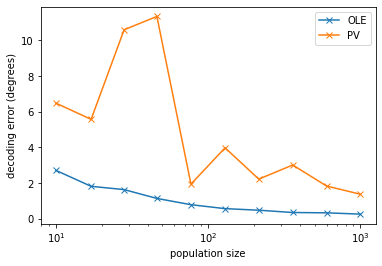

In [10]:
# Set tuning curve parameters for all neurons
r_max = 1.0
alpha = -0.14
# Pick population sizes to test
n_test = np.round(np.logspace(1, 3, 10)) # a range of population sizes from 10 to 1000
# Generate stimuli (i.e. reach directions) over which to average decoding error
m = 200 # number of stimuli over which to evaluate decoding error
stimuli = rd.rand(m) * 2 * np.pi
# Placeholders
error = np.zeros((len(n_test), 2))
# For each population size:
for i, n in enumerate(n_test):
    # Generate random theta_i parameters for each neuron in the population
    theta_i = rd.rand(int(n)) * 2 * np.pi
    # Estimate OLE decoding vectors for each neuron
    V_ole = OLE_fit(theta_i, alpha, r_max)
    # Estimate preferred directions of each neuron
    pref = [pref_direction([r_max, alpha, th]) for th in theta_i]
    V_pv = np.array([vec(p) for p in pref]).T
    # Simulate respones to each stimulus
    resp = np.array([simulate(stimuli, [r_max, alpha, th]) for th in theta_i])
    # Decode from each of these responses using OLE and PV algorithms
    vhat_ole = V_ole @ resp
    vhat_pv = V_pv @ resp
    # Compute average angular decoding error
    for vole, vpv, s in zip(vhat_ole.T, vhat_pv.T, stimuli):
        vstim = vec(s)
        error[i, 0] += angular_error(vole, vstim) / m
        error[i, 1] += angular_error(vpv, vstim) / m
# Plot angular decoding error as a function of population size for each algorithm
fig, ax = plt.subplots()
ax.plot(n_test, error, 'x-')
ax.set_xscale('log')
ax.set_xlabel('population size')
ax.set_ylabel('decoding error (degrees)')
ax.legend(['OLE', 'PV'])

### 3.3) [*Advanced*] Derive the optimal encoding model for a linear decoder
The OLE algorithm computes the optimal linear decoder for any given encoding model. But if we think that the brain actually uses a linear decoder to extract information about the stimulus, you might expect that the encoding model it uses is optimized for such a decoder. 

Suppose the decoder used by the brain is given by
\begin{equation}
    \hat{\mathbf{v}}^{\text{brain}} = \mathbf{V}\mathbf{r}(s)
\end{equation}
where $\mathbf{V}$ is some $2 \times n$ matrix. Assume a tuning curve + noise model for $\mathbf{r}(s)$ and find the tuning curve function that minimizes the decoding error $\mathbb{E}\left[ \| \mathbf{v}(s) - \mathbf{Vr} \|^2 \right]$.

Compare your answer to the tuning curves observed in the cricket cercal system and primate primary motor cortex.

## 4) Maximum likelihood decoding
An obvious limitation of the above decoding schemes is their reliance on a linear operation. While such schemes may work for simple linear codes like those explored above, linear decoding won't work for more complex non-linear codes. Indeed, this choice of decoder was a priori entirely arbitrary. Can we come up with a more principled and general approach to decoding?

One such approach is called maximum likelihood decoding. Given an encoding model, we can actually compute the probability of observing a given neural response $r_i(s)$ to a particular stimulus $s$, or a "likelihood" of observing that response. Maxium likelihood decoding thus consists of finding the stimulus value that maximizes the likelihood of an observed set of responses $\{r_i\}$:
\begin{equation}
    \hat{s}^{\text{ML}} = \arg \max_s P(\{r_i\}|s) = \arg \max_s \log P(\{r_i\}|s)
\end{equation}
The second equality holds because the logarithm is monotonic, and we write it here because often log probabilities are much easier to optimize than the probability density functions themselves.

The main challenge inherent to this algorithm is that we never actually know the true encoding model, which we need in order to compute $P(\{r_i\}|s)$. Thus, we typically assume some kind of parametric form for $P(r_i| s)$ (as we did above) and fit its parameters to data. This is analagous to the problem of estimating the decoding vectors $\hat{\mathbf{v}}_i$ in the linear decoding algorithms above.

In the below we'll just assume we know the parameters and entirely side step this problem. But it is worth mentioning that this problem can often be highly non-trivial and a large body of statistics and machine learning literature is dedicated to solving it.

### <span style="color:green">Poisson spiking</span>
Let's build furthher on the tuning curve plus Gaussian noise model by incorporating some more biological realism. We'll first assign an actual physical interpretation to the "neural response" $r_i(\theta)$, by making it a spike count. The tuning curve $f_i(\theta)$, which by definition is the expected neural response to stimulus $\theta$, is thus now interpreted as the mean number of spikes emitted in response to stimulus $\theta$ over some interval of time after stimulus presentation. Because spike counts are discrete (i.e. you can have 3 or 4 spikes but not 3.55), Gaussian noise is no longer appropriate. Instead, we'll take the distribution of responses $r_i(\theta)$ for a given stimulus to be Poisson distributed:
\begin{equation}
    P(r_i | \theta) = \frac{f_i(\theta)^{r_i}e^{-f_i(\theta)}}{r_i!}
\end{equation}

Here's a function for simulating from a Poisson spiking model of the cricket cercal system, using the recitfied cosine tuning curve for $f_i(\theta)$, with parameters set to those measured by Miller, Jacobs & Theunisssen (1991) for $i = 1, \ldots, 4$. 

In [11]:
r_max = 100.0 # I made this up to get nice answers below - this value was not measured by Miller et al.
alpha = -0.14
theta_i = np.arange(np.pi/4, 2*np.pi, np.pi/2)
def simulate(stimuli):
    """
    Given list of m stimuli, simulate responses of a population of 
    cricket cercal interneurons with Poisson spiking
    Arguments:
        stimuli: list of m stimuli
    Outputs:
        4 x m array, with responses of each of the cercal neurons to the m stimuli
    """
    return np.array([rd.poisson(cosine_tuning(stimuli, [r_max, alpha, th])) for th in theta_i])

### 4.1) Write a function to evaluate the log likelihood of the cricket cercal neuron population and perform maximum likelihood decoding
Simulate responses from the population to a random wind direction. Plot the log likelihood of these observed spike counts evaluated at a range of wind directions between 0 and $2\pi$, and perform maximum likelihood decoding by finding the wind direction at which this function reaches its maximum (don't try doing this analytically, there is no closed form solution - or at least I couldn't find one). Compare this to the true wind direction.

*Tip*: to avoid dividing by zero, it might be necessary to add a small number to denominators of some fractions. It suffices to add a very small number like $1^{-10}$, which can be written in Python as `1e-10`.

In [12]:
def log_lik(resp, stimuli):
    """
    Compute the log likelihood of neural responses under the Poisson cercal interneuron model
    Arguments:
        resp: 4-dimensional vector, with responses from the four interneurons (i.e. spike counts)
        stimuli: list of stimuli at which to evaluate the log likelihood
    Outputs:
        vector with log likelihood evaluated at each stimulus value in stimuli
    """
    f = np.array([cosine_tuning(stimuli, [r_max, alpha, th]) for th in theta_i])
    eps = 1e-10
    logf = np.log(f + eps * (f == 0)) # eliminate 0s so that log likelihood can be valuated
    return (resp[:, np.newaxis] * logf - f).sum(0)

Text(0.5, 1.0, 'decoding error = 3.52 degrees')

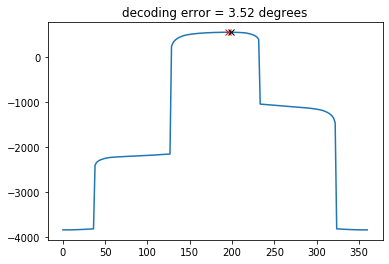

In [13]:
# Simulate cercal neuron population in response to a random wind direction
stim = rd.rand() * 2 * np.pi # random wind direction
resps = simulate(stim) # simulate
# Evaluate log likelihood of these responses at a range of stimulus values
stim_eval = np.linspace(0, 2 * np.pi, 200)
loglik = log_lik(resps, stim_eval)
# Plot the log likelihood
fig, ax = plt.subplots()
ax.plot(np.rad2deg(stim_eval), loglik)
# Find the maximum likelihood estimate and mark it on the curve
shat_ml = stim_eval[np.argmax(loglik)]
ax.plot(np.rad2deg(shat_ml), loglik.max(), 'rx')
# Mark the true stimulus value on the curve
ax.plot(np.rad2deg(stim), loglik.max(), 'kx')
# Calculate angular decoding error
error = np.rad2deg(np.abs(shat_ml - stim))
ax.set_title('decoding error = %.2f degrees' % error)

### 4.2) Compare all three decoding algorithms discussed so far
Simulate many trials to a set of ~10 wind directions. For each trial, decode wind direction using all three algorithms and compute angular decoding error. The next cell contains the code needed to do OLE and PV decoding for this new model neuron, I have left it to you to write the same function for maximum likelihood decoding. 

Plot decoding error as a function of true wind direction for each algorithm. How do these curves compare?

In [14]:
stimuli = np.linspace(0, 2*np.pi, 500)

# Estimate preferred directions for the Poisson cercal interneuron population
n_trials = 500
resp = np.zeros((4, len(stimuli)))
for _ in range(n_trials):
    resp += simulate(stimuli) / n_trials
pref = [stimuli[np.argmax(r)] for r in resp]

def pv_decoding(resp, s):
    """
    Given a set of population responses resp, decode the stimulus using the PV algorithm
    and return the angular decoding error with respect to the true stimulus s
    """
    vhat = np.sum([r * vec(p) for r, p in zip(resp, pref)], axis=0)
    return angular_error(vhat, vec(s))

# Estimate OLE decoding vectors for the Poisson cercal interneuron population
r = simulate(stimuli)
rcorr = r @ r.T / m
vstim = np.array([vec(s) for s in stimuli])
rvcorr = r @ vstim / m
V_ole = rvcorr.T @ np.linalg.inv(rcorr)

def ole_decoding(resp, stim):
    """
    Given a set of population responses resp, decode the stimulus using the OLE algorithm
    and return the angular decoding error with respect to the true stimulus s
    """
    vhat = V_ole @ resp
    return angular_error(vhat, vec(s))

In [15]:
def ml_decoding(resp, s):
    """
    Given a set of population responses resp, decode the stimulus using maximum likelihood
    and return the angular decoding error with respect to the true stimulus s
    NOTE: angular errors lie between 0 and 180, e.g. an angular difference of 200 should 
    be quantified as an angular *error* of 160
    """
    stim_eval = np.linspace(0, 2*np.pi, 200)
    loglik = log_lik(resp, stim_eval)
    shat = stim_eval[np.argmax(loglik)]
    diff = np.rad2deg(np.abs(shat - s))
    if diff  <= 180: # angular difference should not be more than 180 degrees!
        return diff
    else:
        return 360 - diff

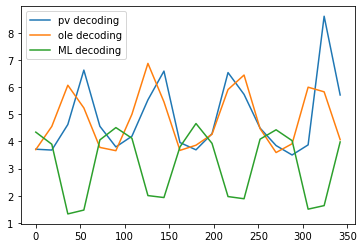

In [16]:
# Pick stimuli at which to evaluate average decoding error
stimuli = np.arange(0, 2 * np.pi, np.pi / 10)
# Placeholders
error = np.zeros((3, len(stimuli)))
n_trials = 200
# For each stimulus:
for i, s in enumerate(stimuli):
    # For each trial:
    for _ in range(n_trials):
        # Simulate population response to the stimulus
        resp = simulate(s)
        # Compute angular decoding error for PV algorithm
        error[0, i] += pv_decoding(resp, s) / n_trials
        # Compute angular decoding error for OLE algorithm
        error[1, i] += ole_decoding(resp, s) / n_trials
        # Compute angular decoding error for maximum likelihood algorithm
        error[2, i] += ml_decoding(resp, s) / n_trials
# Plot average decoding error as a function of wind direction for each decoder
fig, ax = plt.subplots()
ax.plot(np.rad2deg(stimuli), error.T)
ax.legend(['pv decoding', 'ole decoding', 'ML decoding'])

### <span style="color:green">Fisher Information</span>
It turns out the maximum likelihood estimate has some very special theoretical properties, two of which are:
1. The maximum likelihood estimate is *unbiased*:
\begin{equation}
    \mathbb{E}_{P(\{r_i\}|s )}\left[ \hat{s}^{\text{ML}} \right] = s
\end{equation}
which in English means that, on average, the maximum likelihood estimate will give you the right answer.
2. Because it is unbiased, the mean squared decoding error of the maximum likelihood estimate satisfies (and in fact saturates) the *Cramer-Rao bound*:
\begin{equation}
    \mathbb{E}_{P(\{r_i\}|s )}\left[(\hat{s}^{\text{ML}} - s)^2 \right] \geq \frac{1}{\mathbb{E}_{P(\{r_i\}|s )}\left[ \left(\frac{\text{d}}{\text{d} s} \log P(\{r_i\}|s )\right)^2 \right]}
\end{equation}
The denominator on the right-hand side of this inequality is called the **Fisher Information**. It is not a true measure of information in the sense that it is not measured in bits (its units are inverse squared units of the stimulus $s$). But intuitively it measures how informative the log likelihood is about $s$.

In fact the Cramer-Rao bound holds for any unbiased estimator, and the maximum likelihood estimator saturates it (i.e. the mean squared error is equal to the inverse Fisher information). *Biased* estimators, on the other hand, won't share property #1 but could actually have an even lower mean squared error than that predicted by the Fisher Information.

### 4.3) [*Advanced*] Compute the Fisher information of the population
Evaluate it at a number of different wind directions. Compute the average *squared* decoder error at each of these wind directions for each decoding algorithm. Does the maximum likelihood decoder satisfy this Cramer-Rao bound for all wind directions? What about the OLE and PV decoders? Why?

Tip #1: for deriving the Fisher information, recall that the responses of each of the neurons in the population *to a given stimulus* are independent, i.e.
\begin{equation}
    P(\{r_i\}|s) = \prod_i P(r_i|s) \Rightarrow \mathbb{E}[r_ir_j] = \mathbb{E}[r_i]\mathbb{E}[r_j]
\end{equation}

Tip #2: for computing the Fisher information, use the `numpy.ma` module to avoid division by 0 (https://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html)

Tip #3: make sure to keep everything dimensionally consistent. In the case that the stimulus $\theta$ has units of radians, the Fisher information has units radians$^{-2}$. If you want to convert this to degrees, don't forget that `np.rad2deg(\theta ** k)` $\neq$ `np.rad2deg(\theta) ** k` for any $k \neq 1$.

In [17]:
def fprime(stimuli, theta_i):
    """
    Evaluate derivative of rectified cosine tuning curve at a given stimulus s,
    using theta_i tuning curve parameter
    Arguments:
        s: list or array of stimulus values
        theta_i: tuning curve parameter theta*_i (parameters r_max, alpha should be 
                 fixed to the values set above)
    Outputs:
        array of evaluations at each stimulus in s
    """
    return - r_max * np.sin(stimuli - theta_i) * np.clip(np.sign(np.cos(stimuli - theta_i) - alpha), a_max=None, a_min=0) / (1 - alpha)
def fisher_info(stimuli):
    """
    Evaluate fisher information at each stimulus value in stimuli
    Arguments:
        stimuli: list or array of stimulus values
    Outputs:
        array with Fisher information evaluated at each stimulus value in stimuli
    """
    f = np.array([cosine_tuning(stimuli, [r_max, alpha, th]) for th in theta_i])
    fp = np.array([fprime(stimuli, th) for th in theta_i])
    fmasked = np.ma.masked_array(f, mask=(f==0))
    return ((fp ** 2) * (1 / fmasked)).sum(0)

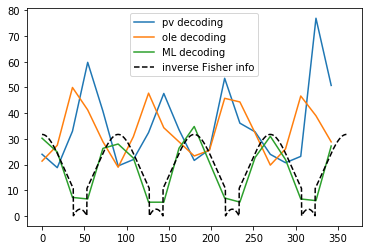

In [18]:
# Pick stimuli at which to evaluate average decoding error
stimuli = np.arange(0, 2 * np.pi, np.pi / 10)
# Placeholders
error = np.zeros((3, len(stimuli)))
n_trials = 200
# For each stimulus:
for i, s in enumerate(stimuli):
    # For each trial:
    for _ in range(n_trials):
        # Simulate population response to the stimulus
        resp = simulate(s)
        # Compute squared angular decoding error for PV algorithm
        error[0, i] += pv_decoding(resp, s) ** 2 / n_trials
        # Compute squared angular decoding error for OLE algorithm
        error[1, i] += ole_decoding(resp, s) ** 2 / n_trials
        # Compute squared angular decoding error for maximum likelihood algorithm
        error[2, i] += ml_decoding(resp, s) ** 2 / n_trials
# Plot average decoding error as a function of wind direction for each decoder
fig, ax = plt.subplots()
ax.plot(np.rad2deg(stimuli), error.T)
# Overlay inverse Fisher information
stim_eval = np.linspace(0, 2 * np.pi, 2000)
ax.plot(np.rad2deg(stim_eval), (np.rad2deg(1 / np.sqrt(fisher_info(stim_eval))) ** 2), color='k', linestyle='--')
ax.legend(['pv decoding', 'ole decoding', 'ML decoding', 'inverse Fisher info'])

## 5) Noise correlations and decoding
So far we have considered neurons with independent noise, i.e. the $\xi_i$ variables in the very first equation for the tuning curve plus noise model were uncorrelated across neurons $i$. In other words, if I show the same stimulus over and over again, the fluctuations of a neuron's response from its mean are uncorrelated to those of any other neuron.

At first glance this might seem like a reasonable assumption to make - a lot of noise sources are indeed independent across neurons, e.g. noisy synaptic transmission, stochasticity of opening and closing of ion channels, noise in dendritic and axonal propagation, etc... But if you really think about it, a lot of what we call "noise" - namely fluctuations across presentations of the same stimulus, termed **noise correlations** - could easily arise from network interactions or even external inputs that are irrelevant to the stimulus we are considering as experimenters measuring tuning curves.

You might say: "ok, that's fine - my tuning curves still fit the data so why should I care about these fluctuations at all?" Well, it turns out these really matter for coding. We'll illustrate a simple example below, but the deeper implications are far from trivial. If you are interested in these, I highly recommend the following two papers, which investigate the effects of noise correlations on coding by formally analyzing their effect on the Fisher information (see above) in a given population code:
* *Abbott, L. F., & Dayan, P. (1999). The effect of correlated variability on the accuracy of a population code. Neural computation, 11(1), 91-101.* This is an absolute classic theoretical neuroscience paper. Highly recommend the introduction for a clear and intuitive explanation of why correlations might matter for coding, and why they're worth studying.
* *Moreno-Bote, R., Beck, J., Kanitscheider, I., Pitkow, X., Latham, P., & Pouget, A. (2014). Information-limiting correlations. Nature neuroscience, 17(10), 1410.* While quite mathematical, this paper elegantly and cleanly points out that only certain kinds of correlations matter for coding. These are exactly the kinds of correlations that we'll explore in the simple example here.

### <span style="color:green">Modelling a 2AFC Task</span>
In this example, we'll model what in the experimental neuroscience literature is called a **two-alternative forced choice task** (2AFC). The task simply consists of presenting a cue to an animal that indicates to them which of two choices they should choose. The idea behind such tasks is that the animal's choices on each trial should tell us something about their perceptual and decision-making abilities.

In our model, we'll let the stimulus take on one of two values: $s = 0$ or $s = 1$. We'll assume that this stimulus identity is encoded in a population of two neurons $r_1, r_2$ via the following noisy responses:
\begin{equation}
    \begin{bmatrix}
        r_1 \\ 
        r_2
    \end{bmatrix}
    \sim 
    \begin{cases}
        \mathcal{N}(\mathbf{\mu}_0, \mathbf{\Sigma}) & \text{if }s = 0 \\
        \mathcal{N}(\mathbf{\mu}_1, \mathbf{\Sigma}) & \text{if }s = 1
    \end{cases}
    \quad \text{where} \quad 
    \mathbf{\Sigma} = 
    \begin{bmatrix}
        \sigma^2 & c \\
        c & \sigma^2
    \end{bmatrix}
\end{equation}
and we'll call the vector of neural responses on the left $\mathbf{r}$. This is a kind of discrete tuning curve + noise model, where, exactly as above, we have assigned a mean neural response for each possible value of the stimulus (which now takes on only two discrete values). As before, the noise distribution is the same for each stimulus, but now we are modelling the whole population covariance rather than just the individual neuron variances (the earlier case is equivalent to setting $c=0$).

The success of the animal then hinges on the downstream decision-making areas being able to decode stimulus identity from this two-neuron population in order to make the right decision. We'll then ask the question: *how is decoding accuracy affected by noise correlations in the population?* Noise correlations in this system arise when the off-diagonal terms $c$ of the covariance matrix $\mathbf{\Sigma}$ are non-zero.

The only reason we make our model population so small is so that we can visualize our results, which will make the effect of noise correlations on this task very clear. But the same intuitions generalize to arbitrarily sized populations.

Here is a function for simulating responses from this population:

In [19]:
def simulate(s, params):
    """
    Given tuning curve parameters and a stimulus s, simulate responses of
    model population of two neurons in a 2AFC task
    Arguments:
        s: stimulus (1 or 0)
        params: list of parameters
            params[0]: mean response to stimulus 0
            params[1]: mean response to stimulus 1
            params[2]: variance parameter sigma^2
            params[3]: correlation parameter c
    Outputs:
        2-dimensional vector of simulated population response to the given stimulus
    """
    mu_0, mu_1, sigma2, c = params
    cov = np.array([[sigma2, c], [c, sigma2]])
    if s == 0:
        return mu_0 + la.sqrtm(cov) @ rd.randn(2)
    if s == 1:
        return mu_1 + la.sqrtm(cov) @ rd.randn(2)

### 5.1) Simulate responses to each stimulus and plot them as points in (2D) state space
Let
\begin{equation}
    \mathbf{\mu}_0 = 
    \begin{bmatrix}
        1 \\
        2
    \end{bmatrix}, \quad
    \mathbf{\mu}_1 = 
    \begin{bmatrix}
        2 \\
        1
    \end{bmatrix}, \quad
    \sigma^2 = 0.2
\end{equation}
Simulate responses to many trials of each stimulus under three settings of $c$:
\begin{equation}
    c = 0, \quad\quad c = 0.15, \quad\quad c = -0.15
\end{equation}
Plot the responses under each of these covariances in separate plots side-by-side. Which of these covariance matrices imply strong noise correlations? In which case do you envision frequently making decoding errors?

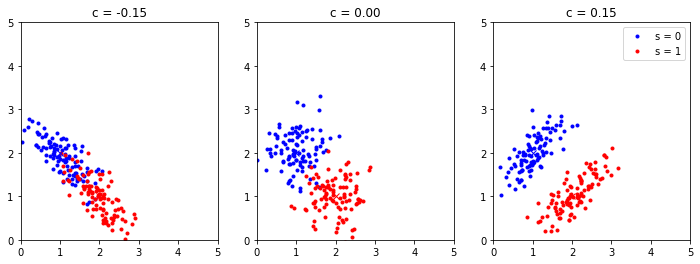

In [20]:
mu_0 = np.array([1, 2])
mu_1 = np.array([2, 1])
sigma2 = 0.2
# Pick values of c to test
c_test = [-0.15, 0, 0.15]
n_trials = 100
# Generate axes for plotting, set axes sizes so that each plot has same x and y scale
fig, axs = plt.subplots(1, len(c_test), figsize=((4 * len(c_test), 4)))
# For each value of c:
for c, ax in zip(c_test, axs):
    params = [mu_0, mu_1, sigma2, c]
    # For each stimulus:
    for s, col in zip([0, 1], ['b', 'r']):
        r = np.zeros((2, n_trials))
        # For each trial:
        for i in range(n_trials):
            # Simulate responses to the stimulus
            r[:, i] = simulate(s, params)
        # Plot them with a color corresponding to that stimulus
        ax.plot(r[0], r[1], '.', color=col, label='s = %i' % s)
        ax.set_title('c = %.2f' % c)
# Mark the mean responses
[ax.plot(mu_0[0], mu_0[1], 'bx') for ax in axs]
[ax.plot(mu_1[0], mu_1[1], 'rx') for ax in axs]
# Formatting
[ax.set_xlim([0, 5]) for ax in axs]
[ax.set_ylim([0, 5]) for ax in axs]
ax.legend()

### 5.2) Write a function to perform maximum likelihood decoding from this population
Note that this case is particularly easy compared to the previous ones since the stimulus can only take on two possible values. Thus, all we need to know to perform maximum likelihood decoding is which stimulus has the higher likelihood. We can encapsulate this comparison in a single number, called the **log-likelihood ratio**:
\begin{equation}
    \gamma = \log\frac{P(\mathbf{r}|s = 1)}{P(\mathbf{r}|s = 0)} = \log P(\mathbf{r}|s = 1) - \log P(\mathbf{r}|s = 0)
\end{equation}
We can then perform maximum likelihood decoding by simply looking at $\gamma$: 
\begin{equation}
\hat{s}^{\text{ML}} = 
\begin{cases}
    1 & \text{if } \gamma > 0 \\
    0 & \text{else}
\end{cases}
\end{equation}
Write a function that computes the log likelihood ratio and decode from the populations with each of the values of $c$ used above. Calculate the percent of trials in which the stimulus was correctly decoded - how does this vary with $c$?

In [21]:
def log_lik_ratio(resp, params):
    """
    Given tuning curve parameters, compute log 
    likelihood ratio of population response resp
    Arguments:
        resp: 2-dimensional vector with responses of each neuron in the population
        params: list of parameters, as in simulate() function defined above
    Outputs:
        scalar, the log likelihood ratio
    """
    mu_0, mu_1, sigma2, c = params
    cov = np.array([[sigma2, c], [c, sigma2]])
    cov_inv = np.linalg.inv(cov)
    return -0.5 * ( (r - mu_1) @ cov_inv @ (r - mu_1) - (r - mu_0) @ cov_inv @ (r - mu_0))

Text(0, 0.5, 'percent correct')

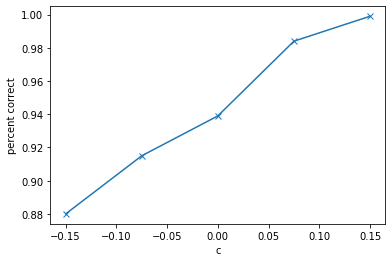

In [22]:
# Pick values of c to test
c_test = np.linspace(-0.15, 0.15, 5)
n_trials = 1000 # number of trials to simulate
# Placeholders
n_correct = np.zeros(len(c_test))
# For each value of c:
for i, c in enumerate(c_test):
    params = [mu_0, mu_1, sigma2, c]
    # For each trial:
    for _ in range(n_trials):
        # Sample a random stimulus
        s = np.round(rd.rand())
        # Simulate response on this trial
        r = simulate(s, params)
        # Compute log likelihood ratio
        g = log_lik_ratio(r, params)
        # Decode and check if correct
        shat = (g > 0)
        n_correct[i] += (shat == s)
# Plot percent correct as a function of c
fig, ax = plt.subplots()
pct_correct = n_correct / n_trials
ax.plot(c_test, pct_correct, 'x-')
ax.set_xlabel('c')
ax.set_ylabel('percent correct')

### 5.3) [*Advanced*] Derive an expression for the expected log likelihood ratio $\gamma$ given a stimulus, i.e. $\mathbb{E}_{P(\mathbf{r}|s)}[\gamma]$. What does this expression tell you about the effect of the covariance matrix on maximum likelihood decoding?
In particular, can you imagine a situation under which you would get the opposite result from above? (Clue: think about different settings for $\mu_0, \mu_1$ - your expression for the expected log likelihood ratio should depend on the relationship between these and the covariance matrix $\mathbf{\Sigma}$)